#### 패키지 준비

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# 모델을 구성하기위한 객체
from tensorflow.keras.models import Sequential
# 모델에 학습층을 쌓기 위한 클래스
from tensorflow.keras.layers import Dense
# 데이터를 훈련용과 테스트용으로 나누는 기능
from sklearn.model_selection import train_test_split

# 학습에 대한 콜백함수 처리용 패키지 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# 표준화 처리 패키지
from sklearn.preprocessing import StandardScaler

# 보스턴 집값 데이터를 로드하기 위한 객체 참조
from sklearn import datasets

from sklearn.decomposition import PCA # 주성분 분석용 패키지
from pca import pca # 주성분 분석 결과 시각화를 위한 패키지

#### 데이터 불러오기

In [2]:
# 데이터셋이 사이킷런에 내장되어있음으로 로드하여 활용

# 데이터 로드하기
dataset = datasets.load_boston()
# 데이터 설명 출력
print(dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
# 데이터 프레임 구성

boston_df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
boston_df['MEDV'] = dataset.target
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


#### 데이터 전처리

In [4]:
# 결측치 확인

boston_df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

#### EDA

In [5]:
# 각 변수들의 정보 조회

boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [6]:
# 기본 통계 확인

boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
# 데이터 표준화

scaler = StandardScaler()
std_boston_df = pd.DataFrame(scaler.fit_transform(boston_df), columns=boston_df.columns, index=boston_df.index)
std_boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,0.159686
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,-0.101524
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,1.324247
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,1.182758
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,1.487503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.413229,-0.487722,0.115738,-0.272599,0.158124,0.439316,0.018673,-0.625796,-0.982843,-0.803212,1.176466,0.387217,-0.418147,-0.014454
502,-0.415249,-0.487722,0.115738,-0.272599,0.158124,-0.234548,0.288933,-0.716639,-0.982843,-0.803212,1.176466,0.441052,-0.500850,-0.210362
503,-0.413447,-0.487722,0.115738,-0.272599,0.158124,0.984960,0.797449,-0.773684,-0.982843,-0.803212,1.176466,0.441052,-0.983048,0.148802
504,-0.407764,-0.487722,0.115738,-0.272599,0.158124,0.725672,0.736996,-0.668437,-0.982843,-0.803212,1.176466,0.403225,-0.865302,-0.057989


#### 데이터 셋 분할

In [8]:
# 랜덤시드 고정

np.random.seed(777)

In [9]:
# 표준화 된 결과를 독립변수와 종속변수로 구분하기

# 독립변수들만 모여 있는 데이터프레임 정의
x_data_set = std_boston_df.drop('MEDV', axis=1)
# 종속변수만 있는 데이터프레임 정의
y_data_set = std_boston_df.filter(['MEDV'])

print("독립변수 데이터셋 크기: %s, 종속변수 데이터셋 크기: %s" % (x_data_set.shape, y_data_set.shape))


독립변수 데이터셋 크기: (506, 13), 종속변수 데이터셋 크기: (506, 1)


In [10]:
# PCA 분석 (주성분 분석)을 활용하여 연관성 높은 변수 찾기

# 주성분 분석의 대상 컬럼 수를 독립변수의 전체 컬럼의 길이로 설정
model = pca(n_components=len(x_data_set.columns))
# 표준화 결과를 활용하여 주성분 분석 수행
fit = model.fit_transform(x_data_set)
# 결과 확인
fit['topfeat']

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [13] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[13]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


,PC,feature,loading,type
0,PC1,INDUS,0.346672,best
1,PC2,CHAS,0.454829,best
2,PC3,RM,0.593961,best
3,PC4,CHAS,0.815941,best
4,PC5,PTRATIO,-0.584002,best
5,PC6,B,-0.803455,best
6,PC7,CRIM,0.777607,best
7,PC8,AGE,-0.600823,best
8,PC9,INDUS,0.644416,best
9,PC10,LSTAT,-0.600711,best


In [11]:
# 연관성이 낮은 컬럼은 제거

# 독립변수에서 관련성 없는 요인 삭제하기
pca_x_data_set = x_data_set.drop(['ZN','RAD'], axis=1)
pca_x_data_set

,CRIM,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT
0,-0.419782,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-1.106115,0.113032,0.441052,-1.026501
...,...,...,...,...,...,...,...,...,...,...,...
501,-0.413229,0.115738,-0.272599,0.158124,0.439316,0.018673,-0.625796,-0.803212,1.176466,0.387217,-0.418147
502,-0.415249,0.115738,-0.272599,0.158124,-0.234548,0.288933,-0.716639,-0.803212,1.176466,0.441052,-0.500850
503,-0.413447,0.115738,-0.272599,0.158124,0.984960,0.797449,-0.773684,-0.803212,1.176466,0.441052,-0.983048
504,-0.407764,0.115738,-0.272599,0.158124,0.725672,0.736996,-0.668437,-0.803212,1.176466,0.403225,-0.865302


In [12]:
# 훈련용 데이터와 검증 데이터로 분할

x_train, x_test, y_train, y_test = train_test_split(
                   pca_x_data_set, y_data_set, test_size=0.3, random_state=777)
print("훈련용 데이터셋 크기: %s, 검증용 데이터셋 크기: %s" % (x_train.shape, x_test.shape))

훈련용 데이터셋 크기: (354, 11), 검증용 데이터셋 크기: (152, 11)


#### 모델 개발

In [13]:
# 모델 정의

# 데이터가 단순하고 개수가 적다면 과대적합이 발생할 확률이 높기 때문에 
# 주의하면서 적절한 크기의 모델층을 쌓아야 한다.
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train.columns), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력
# -> 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
# -> linear는 기본값이므로 생략 가능함.
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 학습하기 

result = model.fit(x_train, y_train, epochs = 500, 
                   validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, 
                      min_lr=0.0001, verbose=1)
])

result_df = pd.DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

Epoch 1/500
12/12 [==============================] - 1s 18ms/step - loss: 0.7770 - mae: 0.6063 - val_loss: 0.6369 - val_mae: 0.5441
Epoch 2/500
12/12 [==============================] - 0s 3ms/step - loss: 0.5455 - mae: 0.5079 - val_loss: 0.4861 - val_mae: 0.4871
Epoch 3/500
12/12 [==============================] - 0s 4ms/step - loss: 0.4342 - mae: 0.4645 - val_loss: 0.3978 - val_mae: 0.4509
Epoch 4/500
12/12 [==============================] - 0s 4ms/step - loss: 0.3723 - mae: 0.4230 - val_loss: 0.3311 - val_mae: 0.3940
Epoch 5/500
12/12 [==============================] - 0s 4ms/step - loss: 0.3116 - mae: 0.3672 - val_loss: 0.2875 - val_mae: 0.3584
Epoch 6/500
12/12 [==============================] - 0s 3ms/step - loss: 0.2679 - mae: 0.3446 - val_loss: 0.2515 - val_mae: 0.3421
Epoch 7/500
12/12 [==============================] - 0s 4ms/step - loss: 0.2322 - mae: 0.3207 - val_loss: 0.2323 - val_mae: 0.3226
Epoch 8/500
12/12 [==============================] - 0s 4ms/step - loss: 0.2165 - 

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,0.777033,0.606253,0.636896,0.544108,0.0010
2,0.545452,0.507918,0.486070,0.487059,0.0010
3,0.434223,0.464485,0.397795,0.450942,0.0010
4,0.372323,0.423030,0.331128,0.394017,0.0010
5,0.311587,0.367184,0.287514,0.358396,0.0010
6,0.267898,0.344608,0.251474,0.342075,0.0010
7,0.232196,0.320745,0.232262,0.322606,0.0010
8,0.216513,0.303480,0.218523,0.311083,0.0010
9,0.193132,0.291285,0.206581,0.304614,0.0010


#### 학습 결과 평가

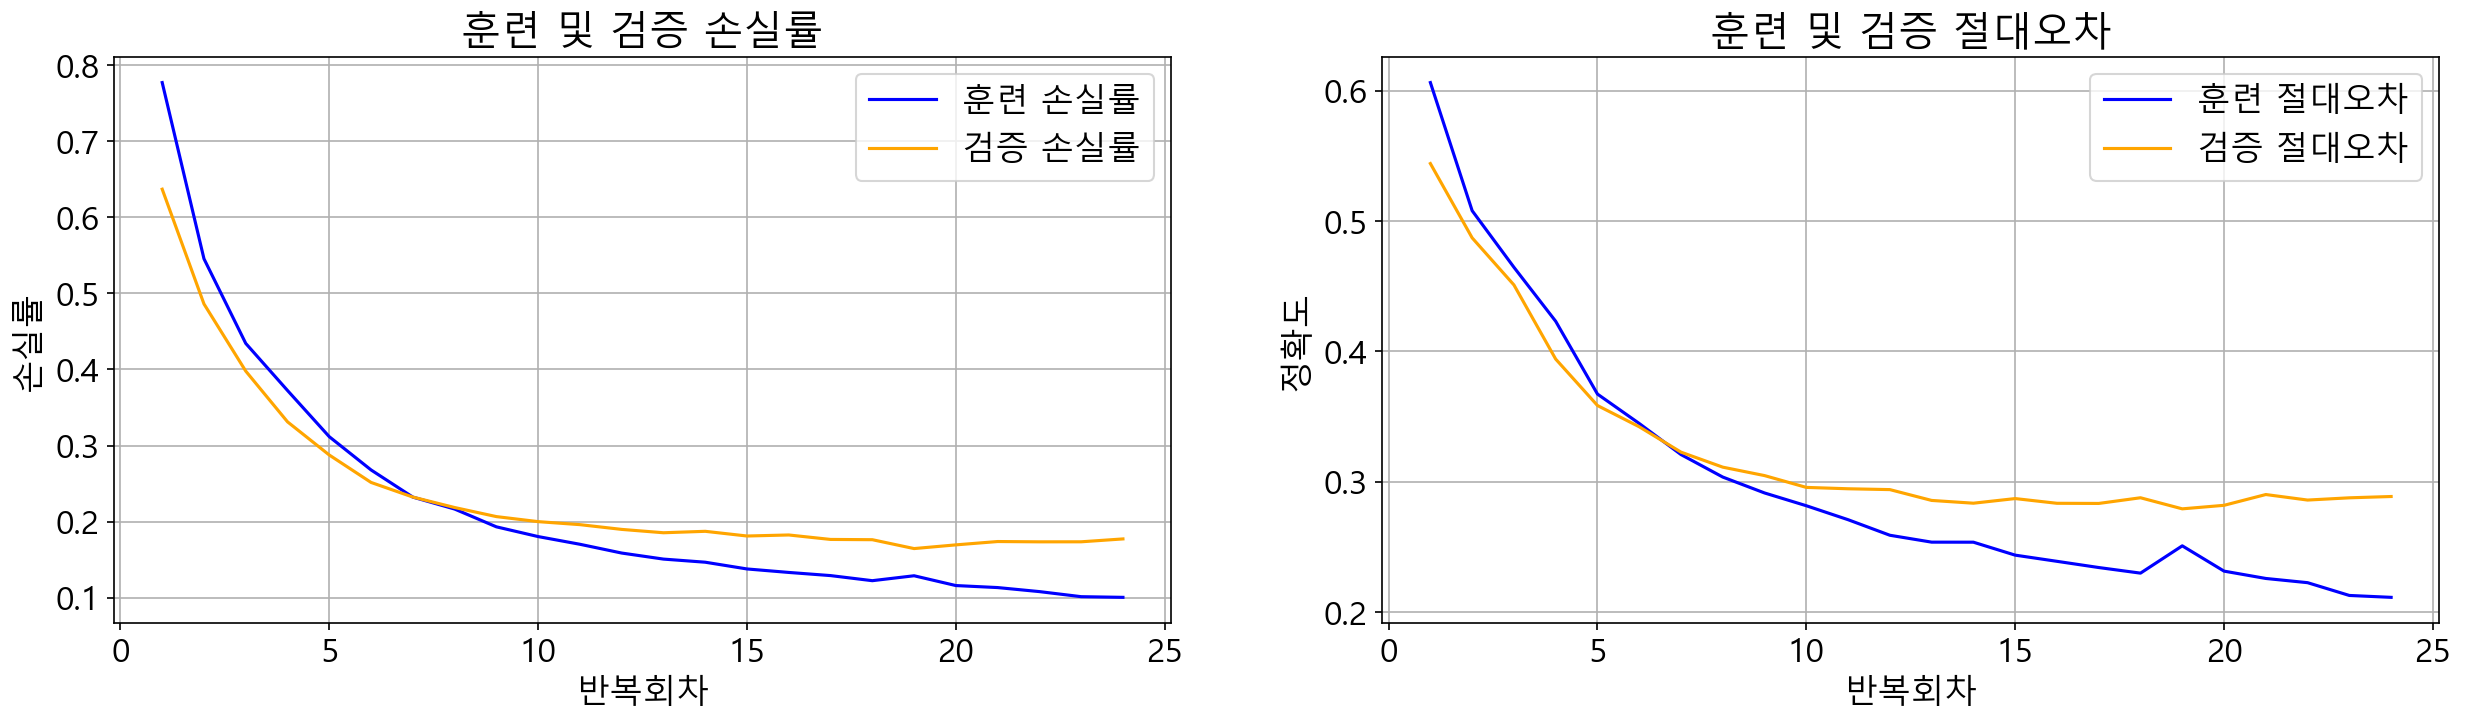

In [15]:
# 학습결과 시각화

# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', 
             label='훈련 손실률', ax=ax1)
sns.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', 
             label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', 
             label = '훈련 절대오차', ax=ax2)
sns.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', 
             label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

In [16]:
# 훈련 데이터에 대한 모델 성능 평가

evaluate = model.evaluate(x_train, y_train)
print("최종 손실률: %f, 최종 절대오차: %f" % (evaluate[0], evaluate[1]))

12/12 [==============================] - 0s 1ms/step - loss: 0.0996 - mae: 0.2086
최종 손실률: 0.099601, 최종 절대오차: 0.208596


#### 학습 결과 적용

In [17]:
# 테스트 데이터에 대한 예측결과 산정

# 검증 데이터를 활용하여 dist 예측하기
test_predictions = model.predict(x_test)
test_predictions

array([[-0.45489565],
       [-1.286059  ],
       [-1.100075  ],
       [ 0.18639702],
       [ 0.9260634 ],
       [-0.27397707],
       [-0.5178756 ],
       [ 2.280518  ],
       [-1.1464727 ],
       [ 2.2535467 ],
       [ 0.31602895],
       [ 0.47573376],
       [-1.2400193 ],
       [-0.35851014],
       [-0.2781701 ],
       [ 1.4953506 ],
       [-1.9076881 ],
       [-0.06002885],
       [ 0.28051284],
       [-0.44716546],
       [-0.621203  ],
       [-0.1964567 ],
       [-1.2401782 ],
       [ 0.43581727],
       [-0.83546144],
       [ 0.16325907],
       [ 0.12789692],
       [ 0.86572593],
       [ 0.00755068],
       [-0.12444085],
       [ 0.5422365 ],
       [ 0.42924786],
       [ 0.42516437],
       [ 0.71206504],
       [ 0.22989228],
       [ 0.6342165 ],
       [-0.8500683 ],
       [ 0.2937392 ],
       [-0.62081814],
       [-0.7883256 ],
       [-0.15230301],
       [-0.5054018 ],
       [-1.3456843 ],
       [-1.0448315 ],
       [-0.75065285],
       [-0

In [18]:
# 2차 배열의 원소들을 1차 배열로 재배치

test_pred_flatten = test_predictions.flatten()
test_pred_flatten

array([-0.45489565, -1.286059  , -1.100075  ,  0.18639702,  0.9260634 ,
       -0.27397707, -0.5178756 ,  2.280518  , -1.1464727 ,  2.2535467 ,
        0.31602895,  0.47573376, -1.2400193 , -0.35851014, -0.2781701 ,
        1.4953506 , -1.9076881 , -0.06002885,  0.28051284, -0.44716546,
       -0.621203  , -0.1964567 , -1.2401782 ,  0.43581727, -0.83546144,
        0.16325907,  0.12789692,  0.86572593,  0.00755068, -0.12444085,
        0.5422365 ,  0.42924786,  0.42516437,  0.71206504,  0.22989228,
        0.6342165 , -0.8500683 ,  0.2937392 , -0.62081814, -0.7883256 ,
       -0.15230301, -0.5054018 , -1.3456843 , -1.0448315 , -0.75065285,
       -0.03825178, -1.2140607 ,  0.07950641, -0.9612552 , -0.5835132 ,
        1.1681771 ,  1.3356352 , -0.6230796 , -0.35488707, -0.2872522 ,
       -0.03761715, -0.2847927 , -1.118102  ,  0.29504964, -0.86652344,
        0.24951422, -0.45078555,  0.46338844, -1.135741  , -0.35628223,
        1.612414  ,  1.8405502 , -0.35369924,  0.38212082, -0.75

In [19]:
# 결과 데이터셋 구성

result_df = x_test.copy()
result_df['실제값'] = y_test['MEDV'].values
result_df['예측값'] = test_pred_flatten
result_df['예측오차'] = result_df['실제값']-result_df['예측값']
result_df

,CRIM,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,실제값,예측값,예측오차
207,-0.391193,-0.079780,-0.272599,-0.567496,-0.714658,0.146691,0.266139,-0.779455,0.066796,0.359148,0.757911,-0.003571,-0.454896,0.451325
425,1.425197,1.015999,-0.272599,1.073787,-0.553671,0.953916,-0.896281,1.530926,0.806576,-3.826496,1.645211,-1.549063,-1.286059,-0.263004
408,0.441097,1.015999,-0.272599,0.365444,-0.951151,1.042817,-1.112527,1.530926,0.806576,-0.460876,1.926960,-0.580409,-1.100075,0.519666
63,-0.405796,-0.876445,-0.272599,-0.878475,0.680083,-0.895234,1.989827,-0.737880,0.575395,0.426579,-0.441977,0.268523,0.186397,0.082126
290,-0.416442,-0.902709,-0.272599,-1.241285,0.821124,-1.446423,0.628275,-0.969512,0.344213,0.441052,-1.306849,0.649454,0.926063,-0.276609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,-0.407957,-0.375976,-0.272599,-0.299707,-0.127698,-0.504068,-0.483566,-0.143951,1.130230,0.403663,0.048631,-0.090641,-0.139758,0.049117
98,-0.410990,-1.203282,-0.272599,-0.947582,2.187372,-1.126378,-0.142536,-0.785394,-0.210622,0.404102,-1.273207,2.314668,2.365443,-0.050776
329,-0.412692,-1.152214,-0.272599,-0.818007,0.068904,-1.826921,0.674814,0.129256,-0.719220,0.203235,-0.744752,0.007313,0.324656,-0.317342
328,-0.412817,-1.152214,-0.272599,-0.818007,-0.593562,-1.521100,0.674814,0.129256,-0.719220,0.282507,-0.376095,-0.351850,-0.232921,-0.118930


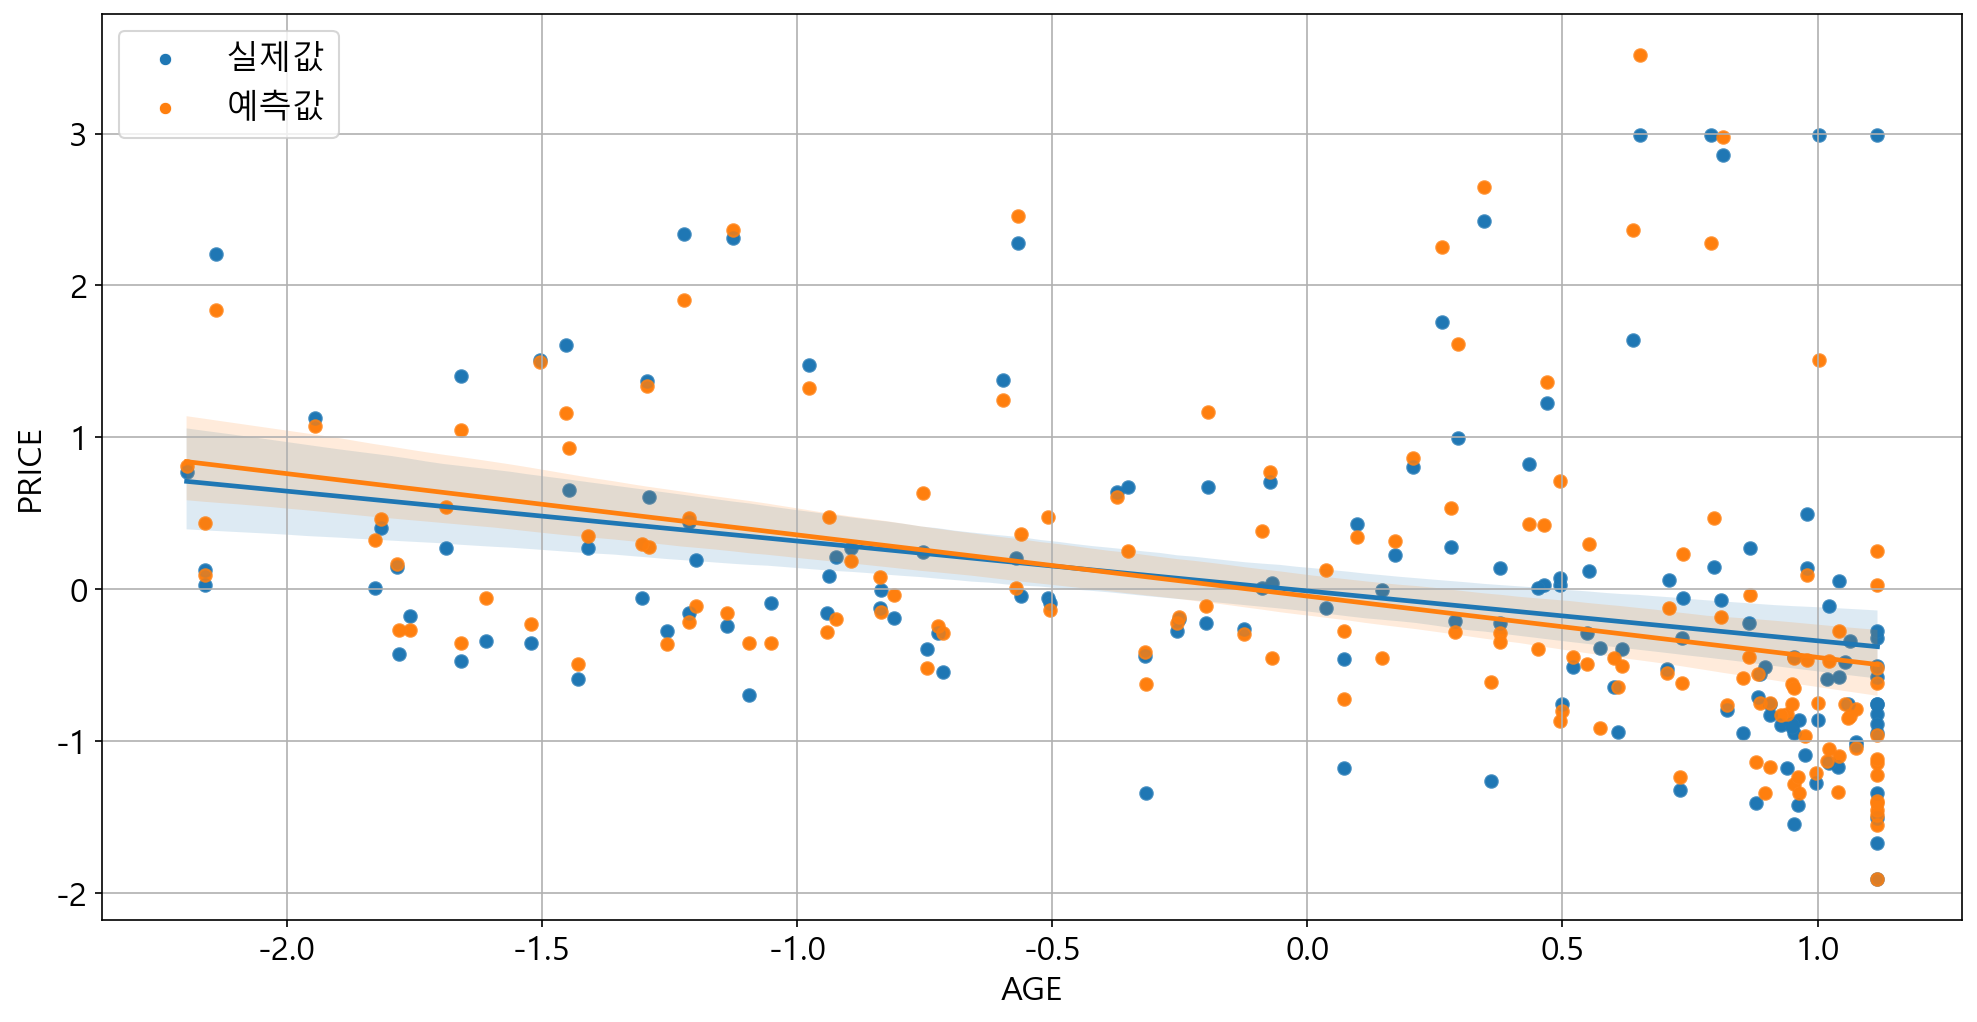

In [21]:
# 실제 결과값과 머신러닝에 의한 예측값 비교

plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(1, 1, figsize=(16, 8), dpi=150)
sns.scatterplot(x='AGE', y='실제값', data=result_df, label='실제값')
sns.scatterplot(x='AGE', y='예측값', data=result_df, label='예측값')
sns.regplot(x='AGE', y='실제값', data=result_df)
sns.regplot(x='AGE', y='예측값', data=result_df)
ax.set_xlabel('AGE')
ax.set_ylabel('PRICE')
ax.legend()
ax.grid()